In [1]:
import ee 
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

ee.Initialize()

csv_file = '/projectnb/modislc/users/chishan/data/MapBiomas/MAPBIOMAS/mapbiomas_85k_col2_1_points_english.csv'
df_points = pd.read_csv(csv_file)


In [2]:
import sys
sys.path.append('research/CODF')
import ccdc_analysis


Analyzing point ID 75755 at latitude -20.40442105, longitude -48.69088251
CCDC Analysis + Landsat Imagery
Location: Lat -20.4044, Lon -48.6909
Time range: 2000-2022

Preparing Landsat collections (2000-2022)...
Total images: 775
Running CCDC algorithm...
Extracting time series data...
Total images: 775
Running CCDC algorithm...
Extracting time series data...
Found 9 CCDC segments

Fetching GLANCE land cover data...
Found 9 CCDC segments

Fetching GLANCE land cover data...
  Retrieved 19 years of GLANCE data
Fetching Landsat thumbnails (SWIR)...
  2011: ✓ (12 images)
  2012: ✓ (7 images)
  2013: ✓ (4 images)
  2014: ✓ (8 images)
  2015: ✓ (7 images)

CCDC Segment Statistics:
Segment 1: 2000-02-24 to 2003-03-04 (1104 days, 93 obs, mean NDVI: 0.453, RMSE: 0.136)
Segment 2: 2003-07-02 to 2005-05-04 (672 days, 55 obs, mean NDVI: 0.570, RMSE: 0.124)
Segment 3: 2005-05-12 to 2006-07-18 (431 days, 41 obs, mean NDVI: 0.622, RMSE: 0.113)
Segment 4: 2006-07-26 to 2008-07-15 (720 days, 59 obs, mea

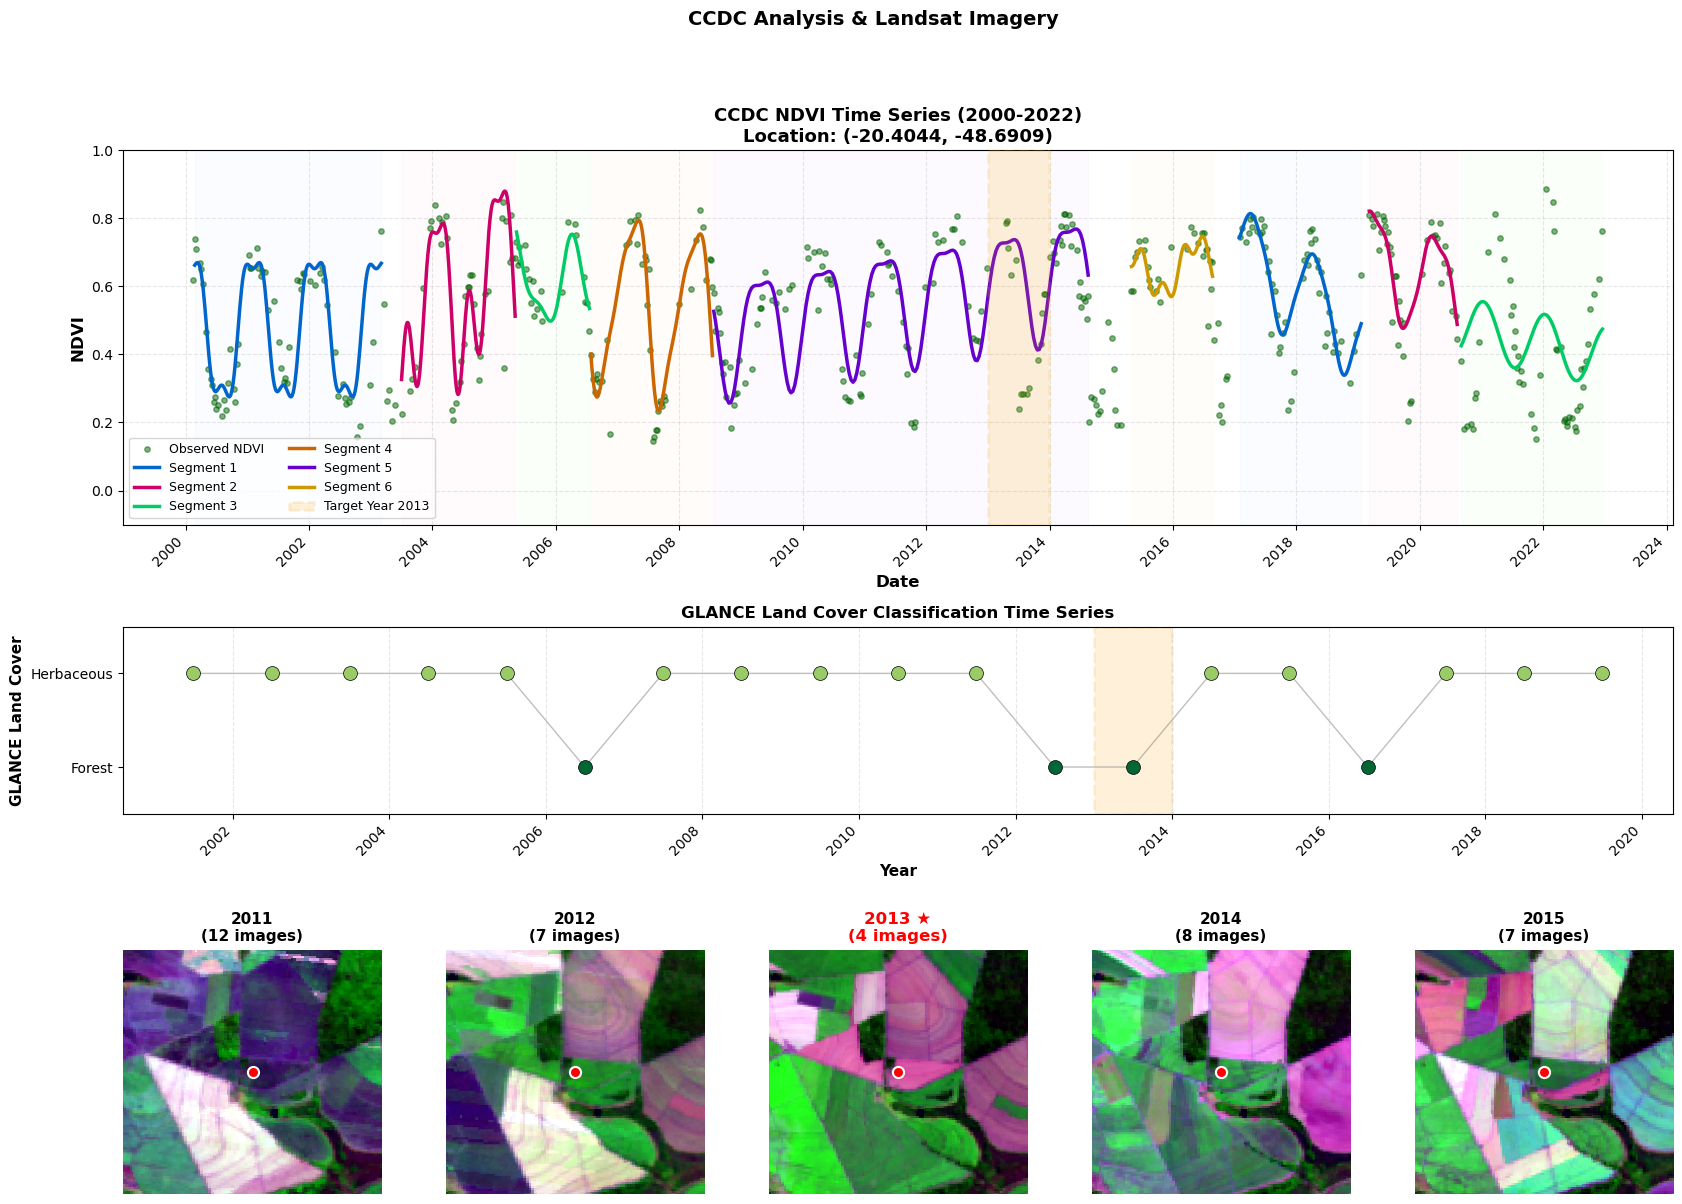

In [48]:
# Define parameters
point_id = 75755  # Replace with your point ID
# Get the point from df_points
point_data = df_points[df_points['TARGETID'] == point_id]

# Use iloc to access the first (and only) row regardless of its index value
lat = float(point_data.iloc[0]['LAT'])
lon = float(point_data.iloc[0]['LON'])

print(f"Analyzing point ID {point_id} at latitude {lat}, longitude {lon}")

start_year = 2000
end_year = 2022
target_year = 2013

result = ccdc_analysis.run_ccdc_analysis(
    lat=lat, lon=lon,
    start_year=start_year, end_year=end_year,
    target_year=target_year,
    # 新增渲染参数
    imagery_combo='SWIR',
    season_months=(6, 10),
    composite_method='median',
    vis_percentiles=(2, 98),
    thumb_dimensions=256
)

# Display the plot
plt.show()


In [ ]:
import ee
ee.Initialize()

def shift_point_one_pixel_north(image: ee.Image, lon: float, lat: float, n: int = 1, direction: str = 'north'):
    """
    在影像的 CRS（米）中，将点按指定方向移动 n 个像元大小。
    方向支持：'north'/'south'/'east'/'west'（大小写不敏感，别名 'n','s','e','w' 亦可）。

    参数：
      - image: ee.Image，用于获取投影与像元大小
      - lon, lat: 原点（WGS84，经纬度）
      - n: 像元数（正整数）
      - direction: 方向字符串（默认 'north'）

    返回：ee.Dictionary
      - point: 平移后的点（WGS84）
      - crs: 使用的CRS
      - meters: 本次使用的位移长度（米）= |nominalScale| * n
      - moved_m: 在该CRS下测得的位移（米），应≈meters
    """
    if image is None:
        raise ValueError('image must be a valid ee.Image')

    dir_str = (direction or 'north').lower()
    if dir_str in ['n']:
        dir_str = 'north'
    elif dir_str in ['s']:
        dir_str = 'south'
    elif dir_str in ['e']:
        dir_str = 'east'
    elif dir_str in ['w']:
        dir_str = 'west'
    elif dir_str not in ['north', 'south', 'east', 'west']:
        raise ValueError("direction must be one of: 'north','south','east','west'")

    # 投影与像元大小（米）
    crs = image.select(0).projection().crs()
    px = ee.Number(image.select(0).projection().nominalScale()).abs()
    meters = px.multiply(ee.Number(n))

    # 原点（WGS84）→ 投影坐标
    p = ee.Geometry.Point([lon, lat])
    p_proj = p.transform(crs, 1)
    xy = ee.List(ee.Geometry(p_proj).coordinates())
    x = ee.Number(xy.get(0))
    y = ee.Number(xy.get(1))

    # 在投影坐标上构造四个方向的候选点（平移 n 个像元）
    p_n_proj = ee.Geometry.Point([x, y.add(meters)], crs)
    p_s_proj = ee.Geometry.Point([x, y.subtract(meters)], crs)
    p_e_proj = ee.Geometry.Point([x.add(meters), y], crs)
    p_w_proj = ee.Geometry.Point([x.subtract(meters), y], crs)

    # 回到 WGS84
    p_n = p_n_proj.transform('EPSG:4326', 1)
    p_s = p_s_proj.transform('EPSG:4326', 1)
    p_e = p_e_proj.transform('EPSG:4326', 1)
    p_w = p_w_proj.transform('EPSG:4326', 1)

    # 原点经纬度
    lat0 = ee.Number(p.coordinates().get(1))
    lon0 = ee.Number(p.coordinates().get(0))

    # 各候选点经纬度
    lat_n = ee.Number(ee.Geometry(p_n).coordinates().get(1))
    lat_s = ee.Number(ee.Geometry(p_s).coordinates().get(1))
    lon_e = ee.Number(ee.Geometry(p_e).coordinates().get(0))
    lon_w = ee.Number(ee.Geometry(p_w).coordinates().get(0))

    # 根据方向选择最符合预期方位的点（避免 CRS 轴向与地理方向不一致的问题）
    def pick_north():
        return ee.Algorithms.If(lat_n.gt(lat0), p_n, p_s)

    def pick_south():
        return ee.Algorithms.If(lat_s.lt(lat0), p_s, p_n)

    def pick_east():
        return ee.Algorithms.If(lon_e.gt(lon0), p_e, p_w)

    def pick_west():
        return ee.Algorithms.If(lon_w.lt(lon0), p_w, p_e)

    p_dir = (pick_north() if dir_str == 'north'
             else pick_south() if dir_str == 'south'
             else pick_east() if dir_str == 'east'
             else pick_west())

    # 在CRS平面下测距（米）
    moved_m = ee.Geometry(p).distance(ee.Geometry(p_dir), 1, crs)

    return ee.Dictionary({'point': p_dir, 'crs': crs, 'meters': meters, 'moved_m': moved_m, 'direction': dir_str})


Original lat,lon = -20.404421, -48.690883
Shifted  lat,lon = -20.404413, -48.690308  (moved north by one pixel)
CRS: EPSG:32622
Pixel size (meters): 60
CRS: EPSG:32622
Pixel size (meters): 60
Moved meters (CRS planar): 59.999999962514266
CCDC Analysis + Landsat Imagery
Location: Lat -20.4044, Lon -48.6903
Time range: 2000-2022

Preparing Landsat collections (2000-2022)...
Moved meters (CRS planar): 59.999999962514266
CCDC Analysis + Landsat Imagery
Location: Lat -20.4044, Lon -48.6903
Time range: 2000-2022

Preparing Landsat collections (2000-2022)...
Total images: 775
Running CCDC algorithm...
Extracting time series data...
Total images: 775
Running CCDC algorithm...
Extracting time series data...
Found 8 CCDC segments

Fetching GLANCE land cover data...
Found 8 CCDC segments

Fetching GLANCE land cover data...
  Retrieved 19 years of GLANCE data
  Retrieved 19 years of GLANCE data
Fetching Landsat thumbnails (SWIR)...
Fetching Landsat thumbnails (SWIR)...
  2012: ✓ (7 images)
  2012:

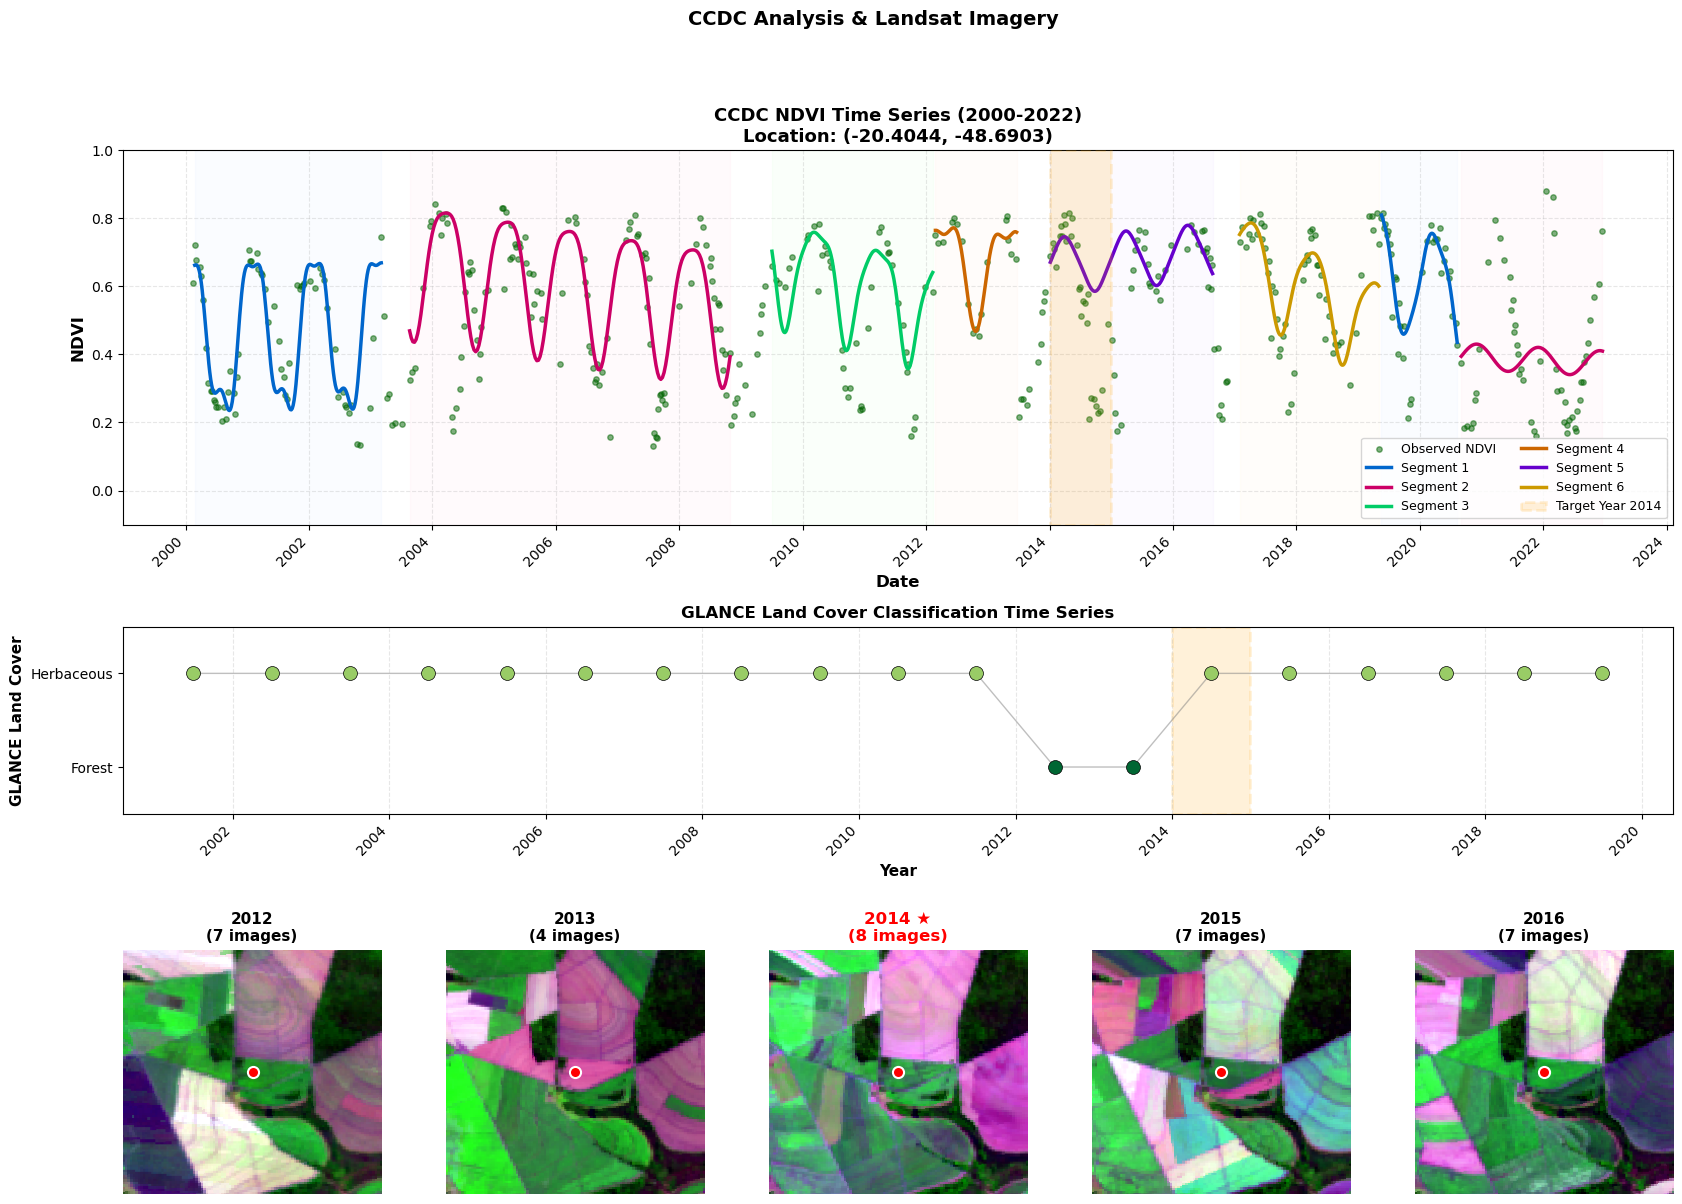

In [54]:
# Define parameters
point_id = 75755  # Replace with your point ID
# Get the point from df_points
point_data = df_points[df_points['TARGETID'] == point_id]

if point_data.empty:
    raise ValueError(f"No point found with TARGETID {point_id}")

# Use iloc to access the first (and only) row regardless of its index value
lat = float(point_data.iloc[0]['LAT'])
lon = float(point_data.iloc[0]['LON'])

# Get a Landsat image to determine the projection for shifting
img = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
       .filterBounds(ee.Geometry.Point([lon, lat]))
       .filterDate('2020-01-01', '2020-12-31')
       .first())

# Shift point north by one pixel (30m) using Landsat projection
shift_result = shift_point_one_pixel_north(img, lon, lat, n=2, direction='east')
shifted_point = ee.Geometry(shift_result.get('point'))
shifted_coords = shifted_point.coordinates().getInfo()
lat_shifted, lon_shifted = shifted_coords[1], shifted_coords[0]

print(f"Original lat,lon = {lat:.6f}, {lon:.6f}")
print(f"Shifted  lat,lon = {lat_shifted:.6f}, {lon_shifted:.6f}  (moved north by one pixel)")
print(f"CRS: {shift_result.get('crs').getInfo()}")
print(f"Pixel size (meters): {shift_result.get('meters').getInfo()}")
print(f"Moved meters (CRS planar): {shift_result.get('moved_m').getInfo()}")

start_year = 2000
end_year = 2022
target_year = 2014

result = ccdc_analysis.run_ccdc_analysis(
    lat=lat_shifted, lon=lon_shifted,
    start_year=start_year, end_year=end_year,
    target_year=target_year,
    # 新增渲染参数
    imagery_combo='SWIR',
    season_months=(6, 10),
    composite_method='median',
    vis_percentiles=(2, 98),
    thumb_dimensions=256
)

# Display the plot
plt.show()

# Display the plot
plt.show()


## Exmain the validation data

Total Amazon validation points: 35289
Amazon points with forest loss (2001-2019): 2155

Processing point 1/6: 37347 (Lat: -9.3352, Lon: -60.4039)
  Validation 2001: Forest Formation → 2019: Pasture
  GLANCE 2001: Forest → 2019: Herbaceous
  MapBiomas 2001: Forest → 2019: Non-Forest

Processing point 2/6: 83846 (Lat: -12.1897, Lon: -51.9124)
  Validation 2001: Forest Formation → 2019: Pasture
  GLANCE 2001: Forest → 2019: Herbaceous
  MapBiomas 2001: Forest → 2019: Non-Forest

Processing point 3/6: 32643 (Lat: -8.9358, Lon: -64.4779)
  Validation 2001: Forest Formation → 2019: Pasture
  GLANCE 2001: Forest → 2019: Herbaceous
  MapBiomas 2001: Forest → 2019: Non-Forest

Processing point 4/6: 22042 (Lat: -8.7181, Lon: -50.8167)
  Validation 2001: Forest Formation → 2019: Mining
  GLANCE 2001: Forest → 2019: Herbaceous
  MapBiomas 2001: Forest → 2019: Non-Forest

Processing point 5/6: 75815 (Lat: -6.6871, Lon: -50.8935)
  Validation 2001: Forest Formation → 2019: Pasture
  GLANCE 2001: For

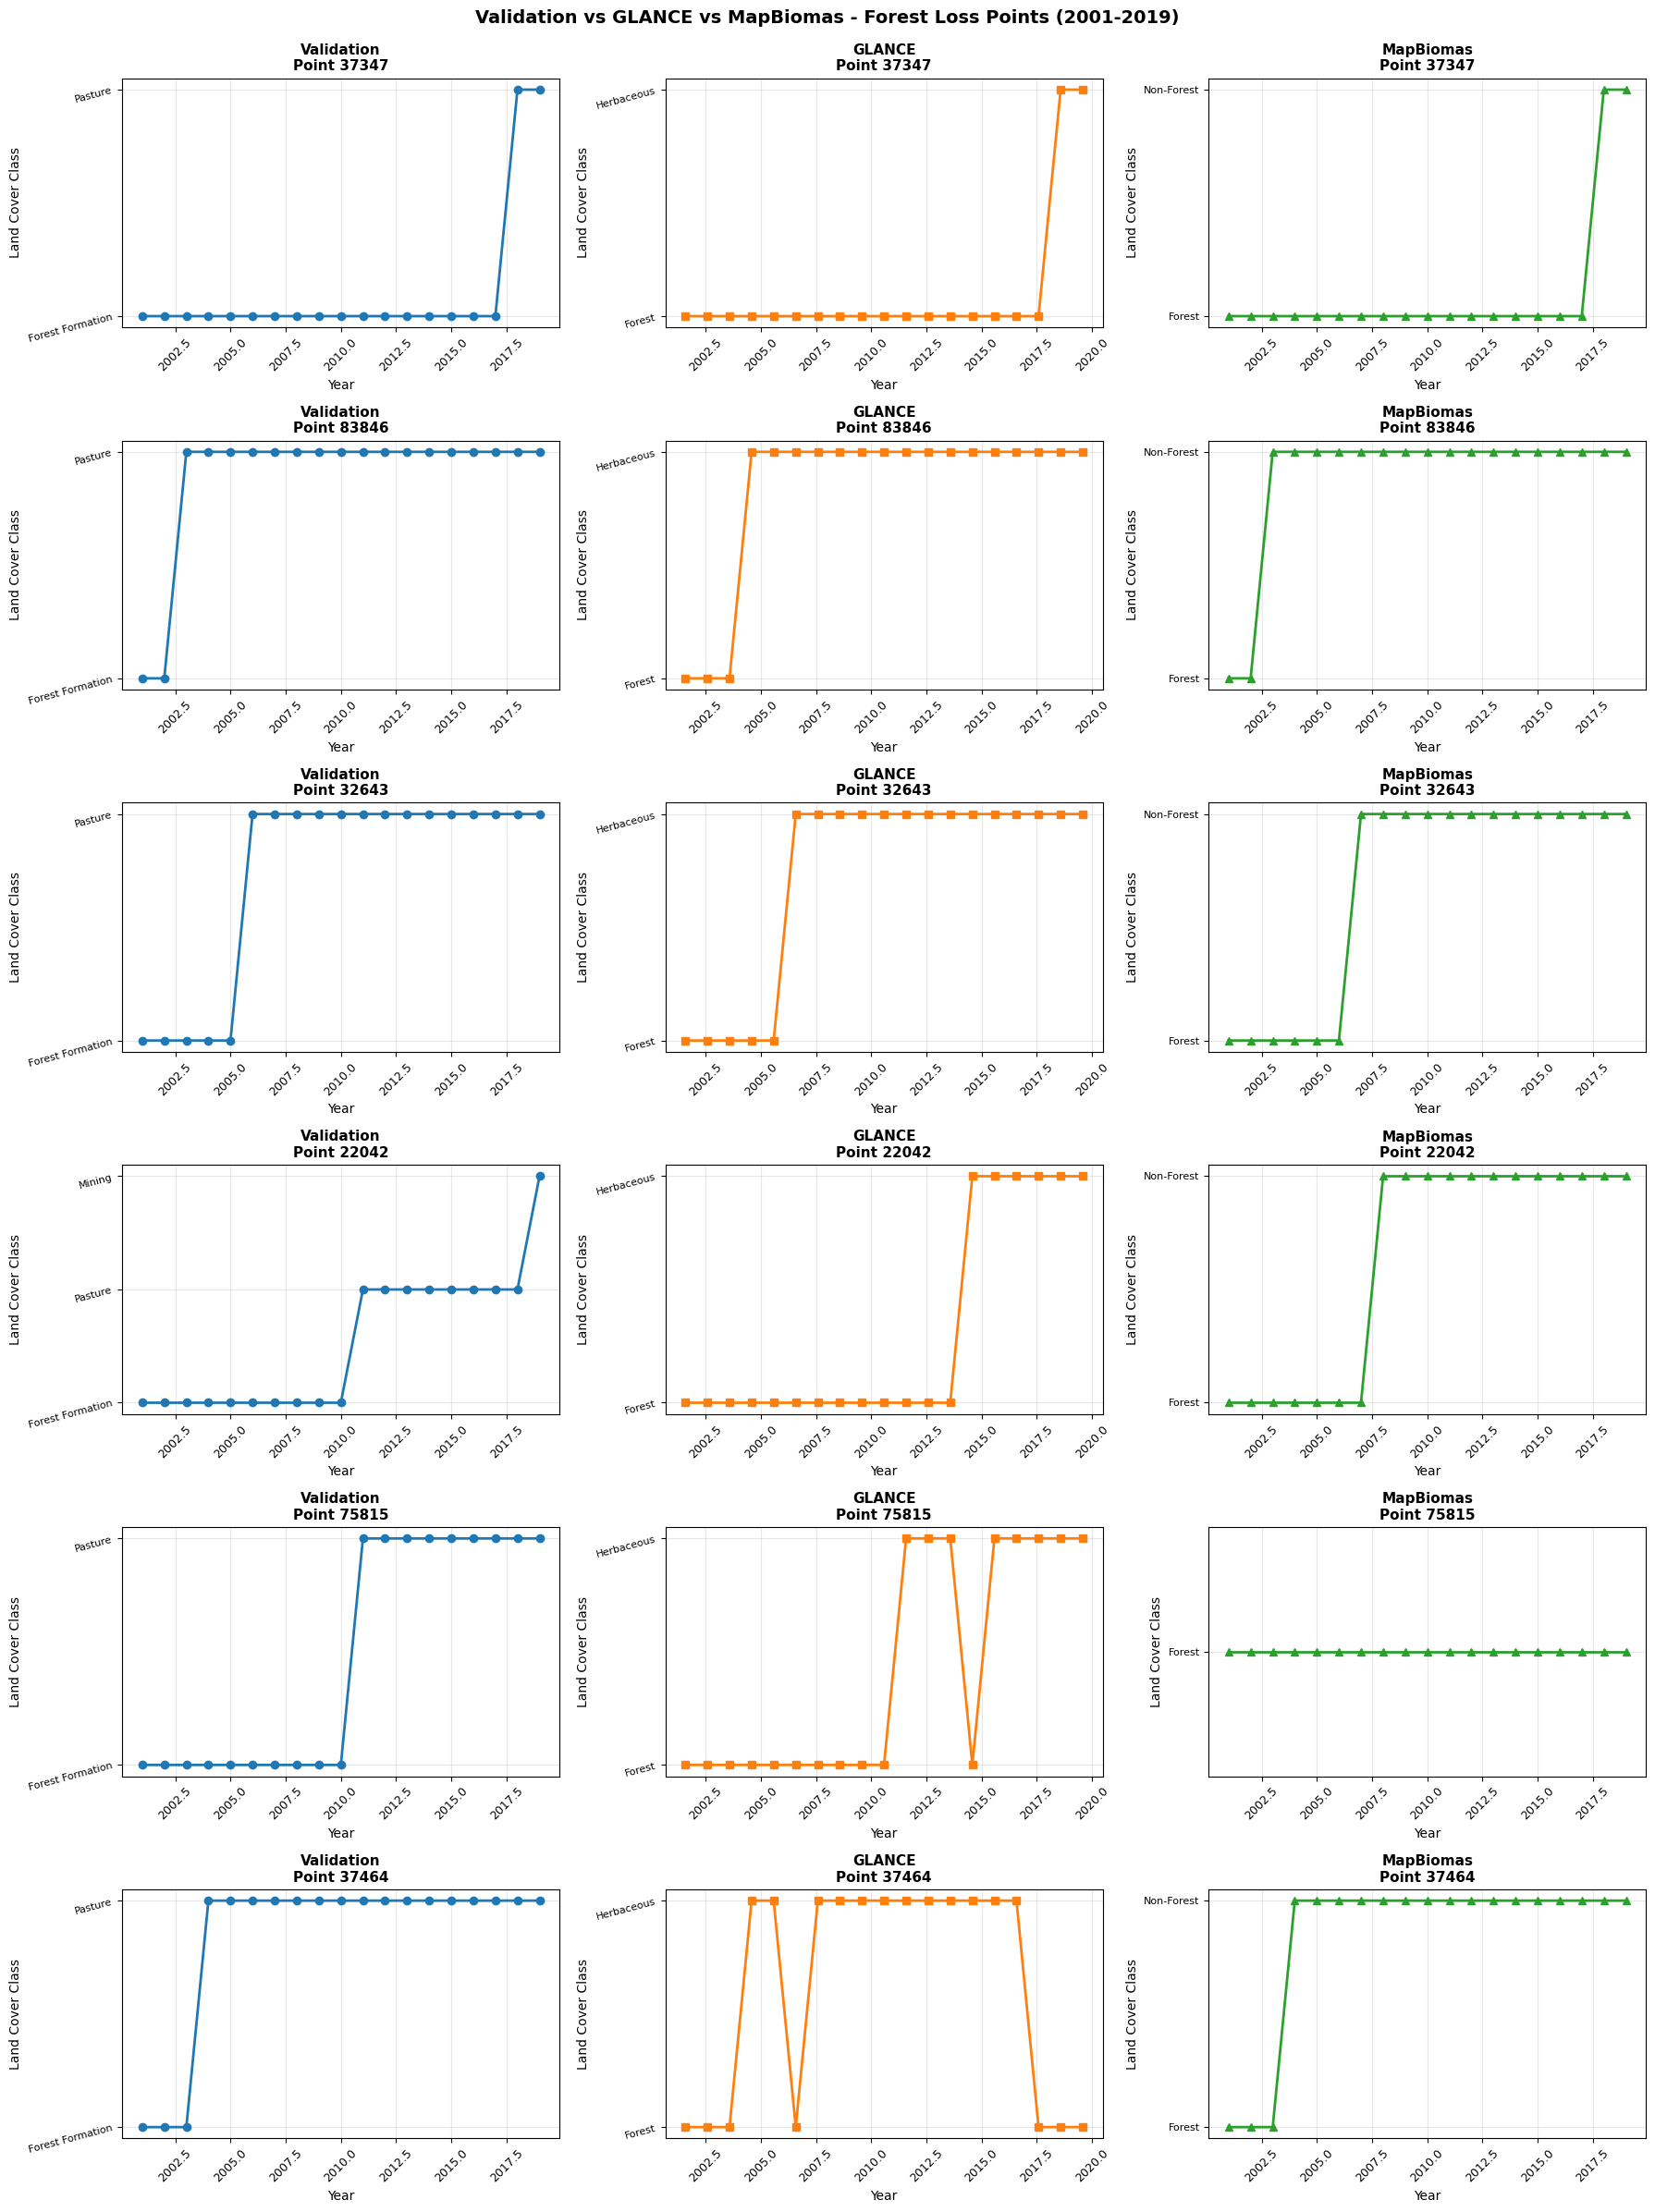


Successfully plotted 6 validation points with GLANCE and MapBiomas comparison


In [19]:
# Sample validation points on GLANCE and MapBiomas and compare time series (2001-2019)
import matplotlib.pyplot as plt
import numpy as np

# Filter for Amazon points with forest transitions
amazon_points = df_points[df_points['BIOMA_250K'] == 'Amazon'].copy()

# Define forest classes in English (from validation data translation)
forest_classes = ['Forest Formation', 'Savanna Formation', 'Flooded Forest', 'Planted Forest']

# Find points that transition from forest to non-forest between 2001-2019
def has_forest_loss_2001_2019(row):
    """Check if point has forest in 2001 and non-forest by 2019"""
    class_2001 = row.get('CLASS_2001', None)
    class_2019 = row.get('CLASS_2019', None)
    if pd.isna(class_2001) or pd.isna(class_2019):
        return False
    return class_2001 in forest_classes and class_2019 not in forest_classes

amazon_points['has_loss'] = amazon_points.apply(has_forest_loss_2001_2019, axis=1)
forest_loss_points = amazon_points[amazon_points['has_loss']].copy()

print(f"Total Amazon validation points: {len(amazon_points)}")
print(f"Amazon points with forest loss (2001-2019): {len(forest_loss_points)}")

# Sample 6 points randomly
n_samples = min(6, len(forest_loss_points))
if n_samples > 0:
    sample_points = forest_loss_points.sample(n_samples, random_state=52)
    
    # Load GLANCE and MapBiomas assets
    GLANCE_IC = ee.ImageCollection('projects/GLANCE/DATASETS/V001')
    MB_IMG = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2')
    mb_forest_classes = [1, 3, 4, 5, 6, 49]  # MapBiomas forest class codes
    
    # Create figure with 3 columns (Validation, GLANCE, MapBiomas) and n_samples rows
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 4*n_samples))
    if n_samples == 1:
        axes = axes.reshape(1, -1)
    
    years_range = list(range(2001, 2020))
    
    for idx, (_, point) in enumerate(sample_points.iterrows()):
        lat = point['LAT']
        lon = point['LON']
        target_id = point['TARGETID']
        
        # Create Earth Engine point
        ee_point = ee.Geometry.Point([lon, lat])
        
        print(f"\nProcessing point {idx+1}/{n_samples}: {target_id} (Lat: {lat:.4f}, Lon: {lon:.4f})")
        
        # === Subplot 1: Validation Data ===
        ax1 = axes[idx, 0]
        validation_classes = [point.get(f'CLASS_{year}', None) for year in years_range]
        ax1.plot(years_range, validation_classes, marker='o', linewidth=2, markersize=6, color='#1f77b4')
        ax1.set_title(f'Validation\nPoint {target_id}', fontsize=11, fontweight='bold')
        ax1.set_xlabel('Year', fontsize=10)
        ax1.set_ylabel('Land Cover Class', fontsize=10)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='x', rotation=45, labelsize=9)
        ax1.tick_params(axis='y', labelsize=8)
        for label in ax1.get_yticklabels():
            label.set_rotation(15)
            label.set_ha('right')
        
        # === Subplot 2: GLANCE ===
        ax2 = axes[idx, 1]
        glance_values = []
        for year in years_range:
            try:
                img = GLANCE_IC.filterDate(f'{year}-01-01', f'{year}-12-31').select('LC').mosaic()
                value = img.reduceRegion(
                    reducer=ee.Reducer.first(),
                    geometry=ee_point,
                    scale=30
                ).getInfo()
                lc_value = value.get('LC', None)
                # GLANCE LC classes: 1=water, 2=snow/ice, 3=developed, 4=barren, 5=forest, 6=shrubland, 7=herbaceous
                glance_class_names = {1: 'Water', 2: 'Snow/Ice', 3: 'Developed', 4: 'Barren', 
                                     5: 'Forest', 6: 'Shrubland', 7: 'Herbaceous'}
                glance_values.append(glance_class_names.get(lc_value, 'Unknown') if lc_value else 'No Data')
            except Exception as e:
                glance_values.append('Error')
                print(f"  GLANCE {year} error: {e}")
        
        ax2.plot(np.array(years_range)+7.0/12.0, glance_values, marker='s', linewidth=2, markersize=6, color='#ff7f0e')
        ax2.set_title(f'GLANCE\nPoint {target_id}', fontsize=11, fontweight='bold')
        ax2.set_xlabel('Year', fontsize=10)
        ax2.set_ylabel('Land Cover Class', fontsize=10)
        ax2.grid(True, alpha=0.3)
        ax2.tick_params(axis='x', rotation=45, labelsize=9)
        ax2.tick_params(axis='y', labelsize=8)
        for label in ax2.get_yticklabels():
            label.set_rotation(15)
            label.set_ha('right')
        
        # === Subplot 3: MapBiomas ===
        ax3 = axes[idx, 2]
        mapbiomas_values = []
        for year in years_range:
            try:
                band_name = f'classification_{year}'
                value = MB_IMG.select(band_name).reduceRegion(
                    reducer=ee.Reducer.first(),
                    geometry=ee_point,
                    scale=30
                ).getInfo()
                mb_value = value.get(band_name, None)
                # Check if forest (codes 1,3,4,5,6,49)
                if mb_value in mb_forest_classes:
                    mapbiomas_values.append('Forest')
                elif mb_value:
                    mapbiomas_values.append('Non-Forest')
                else:
                    mapbiomas_values.append('No Data')
            except Exception as e:
                mapbiomas_values.append('Error')
                print(f"  MapBiomas {year} error: {e}")
        
        ax3.plot(years_range, mapbiomas_values, marker='^', linewidth=2, markersize=6, color='#2ca02c')
        ax3.set_title(f'MapBiomas\nPoint {target_id}', fontsize=11, fontweight='bold')
        ax3.set_xlabel('Year', fontsize=10)
        ax3.set_ylabel('Land Cover Class', fontsize=10)
        ax3.grid(True, alpha=0.3)
        ax3.tick_params(axis='x', rotation=45, labelsize=9)
        ax3.tick_params(axis='y', labelsize=8)
        
        print(f"  Validation 2001: {validation_classes[0]} → 2019: {validation_classes[-1]}")
        print(f"  GLANCE 2001: {glance_values[0]} → 2019: {glance_values[-1]}")
        print(f"  MapBiomas 2001: {mapbiomas_values[0]} → 2019: {mapbiomas_values[-1]}")
    
    plt.suptitle('Validation vs GLANCE vs MapBiomas - Forest Loss Points (2001-2019)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"Successfully plotted {n_samples} validation points with GLANCE and MapBiomas comparison")
    print(f"{'='*80}")
else:
    print("No forest loss points found in Amazon region for 2001-2019 period.")


In [ ]:
df_points


,TARGETID,LON,LAT,BIOMA_250K,CLASS_1985,COUNT_1985,BORDA_1985,CLASS_1986,COUNT_1986,BORDA_1986,...,CONCORD,AMOSTRAS,AMOSTRA_AM,CARTA_2,PROB_AMOS_,PESO_AMOS,DECLIVIDAD,FID,ID_REVISAO,has_change
0,23902,-60.109099,1.966324,Amazon,Forest Formation,3,1,Forest Formation,3,1,...,4,Treinamento,1,NA-20-Z,"6,139945317647E-06","162867,9",D4,0,NaN,False
1,23947,-60.534361,0.467396,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,3,NaN,0,NA-20-Z,"6,20176866388049E-06","161244,324675325",D3,0,NaN,False
2,24072,-60.392337,1.224136,Amazon,Pasture,3,0,Pasture,3,0,...,3,NaN,0,NA-20-Z,"6,1420412258699E-06","162812,32300885",D2,0,NaN,False
3,24079,-60.235761,0.942515,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,4,Treinamento,1,NA-20-Z,"6,15300834369149E-06","162522,126436782",D1,0,NaN,True
4,24119,-61.351199,1.061901,Amazon,"River, Lake and Ocean",3,0,"River, Lake and Ocean",3,0,...,3,Treinamento,1,NA-20-Z,"6,15300834369149E-06","162522,126436782",D1,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85147,69346,-59.366911,-8.337801,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,3,NaN,0,SC-21-V,"6,37554802375989E-06","156849,261627907",D3,0,NaN,False
85148,69367,-57.235208,-9.728393,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,4,NaN,0,SC-21-V,"6,36942059371303E-06","157000,151785714",D2,0,NaN,True
85149,70981,-57.385047,-8.440478,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,3,NaN,0,SC-21-V,"6,39863168247499E-06","156283,413333333",D1,0,NaN,False
85150,71126,-57.442719,-8.065881,Amazon,Forest Formation,3,0,Forest Formation,3,0,...,3,NaN,0,SC-21-V,"6,36942059371303E-06","157000,151785714",D2,0,NaN,False


In [42]:
# Stratified sampling based on number of land cover changes (2000-2019)
import pandas as pd
import numpy as np

# Define the years of interest
sample_years = list(range(2000, 2020))

def count_land_cover_changes(row):
    """Count the number of land cover changes in a time series"""
    classes = [row.get(f'CLASS_{year}', None) for year in sample_years]
    # Remove None/NaN values
    valid_classes = [c for c in classes if pd.notna(c)]
    
    if len(valid_classes) < 2:
        return None  # Not enough data
    
    # Count transitions
    n_changes = 0
    for i in range(1, len(valid_classes)):
        if valid_classes[i] != valid_classes[i-1]:
            n_changes += 1
    
    return n_changes

# Add change count column to df_points
df_points['n_changes'] = df_points.apply(count_land_cover_changes, axis=1)

# Remove rows with insufficient data
df_valid = df_points[df_points['n_changes'].notna()].copy()

# Stratify into 4 groups
no_change = df_valid[df_valid['n_changes'] == 0].copy()
one_change = df_valid[df_valid['n_changes'] == 1].copy()
two_changes = df_valid[df_valid['n_changes'] == 2].copy()
three_plus_changes = df_valid[df_valid['n_changes'] >= 3].copy()

print("="*80)
print("Land Cover Change Stratification (2000-2019)")
print("="*80)
print(f"No change (0):           {len(no_change):6d} points available")
print(f"One change (1):          {len(one_change):6d} points available")
print(f"Two changes (2):         {len(two_changes):6d} points available")
print(f"Three+ changes (≥3):     {len(three_plus_changes):6d} points available")
print(f"Total valid points:      {len(df_valid):6d}")
print("="*80)

# Sample 100 from each stratum (or all available if less than 100)
n_per_stratum = 100
random_seed = 42

sample_no_change = no_change.sample(n=min(n_per_stratum, len(no_change)), random_state=random_seed)
sample_one_change = one_change.sample(n=min(n_per_stratum, len(one_change)), random_state=random_seed)
sample_two_changes = two_changes.sample(n=min(n_per_stratum, len(two_changes)), random_state=random_seed)
sample_three_plus = three_plus_changes.sample(n=min(n_per_stratum, len(three_plus_changes)), random_state=random_seed)

# Combine all samples
stratified_sample = pd.concat([
    sample_no_change,
    sample_one_change,
    sample_two_changes,
    sample_three_plus
], ignore_index=True)

print(f"\nStratified sample composition:")
print(f"  No change:       {len(sample_no_change):3d} points")
print(f"  One change:      {len(sample_one_change):3d} points")
print(f"  Two changes:     {len(sample_two_changes):3d} points")
print(f"  Three+ changes:  {len(sample_three_plus):3d} points")
print(f"  Total sampled:   {len(stratified_sample):3d} points")
print("="*80)


Land Cover Change Stratification (2000-2019)
No change (0):            73212 points available
One change (1):            9580 points available
Two changes (2):           1711 points available
Three+ changes (≥3):        649 points available
Total valid points:       85152

Stratified sample composition:
  No change:       100 points
  One change:      100 points
  Two changes:     100 points
  Three+ changes:  100 points
  Total sampled:   400 points


In [43]:
# Export stratified sample to Earth Engine
import ee, pandas as pd
try:
    ee.Initialize()
except Exception:
    ee.Authenticate()
    ee.Initialize()

years = list(range(2001, 2020))
SCALE = 30               # MapBiomas/GLANCE 均为 30m
EXPORT_FOLDER = 'GEE_exports'    # Google Drive 目标文件夹

# Use the stratified sample created in the previous cell
sample_df = stratified_sample.copy()
n_final = len(sample_df)

print(f"Preparing to export {n_final} stratified points")

# 将 DataFrame 转成 EE FeatureCollection（携带 id、lon、lat、n_changes 属性）
features = []
for i, r in sample_df.iterrows():
    lon, lat = float(r['LON']), float(r['LAT'])
    props = {
        'target_id': int(r['TARGETID']) if 'TARGETID' in r else i,
        'lon': lon,
        'lat': lat,
        'n_changes': int(r['n_changes'])  # Include change count
    }
    features.append(ee.Feature(ee.Geometry.Point([lon, lat]), props))

points_fc = ee.FeatureCollection(features)
print(f'Sampled points: {n_final}')


Preparing to export 400 stratified points
Sampled points: 400


In [44]:
# 使用你代码里的 C10 集成影像
EXPORT_FOLDER = 'GEE_exports'    # Google Drive 目标文件夹，可改

MB_IMG = ee.Image('projects/mapbiomas-public/assets/brazil/lulc/collection10/mapbiomas_brazil_collection10_integration_v2')

mb_band_names = [f'classification_{y}' for y in years]
mb_rename = [f'mb_{y}' for y in years]
mb_img = MB_IMG.select(mb_band_names).rename(mb_rename)

mb_samples = mb_img.sampleRegions(
    collection=points_fc,
    scale=SCALE,
    geometries=False,   # 不导出几何，减小体积；lon/lat 作为属性已保留
    tileScale=4
)

ee.batch.Export.table.toDrive(
    collection=mb_samples,
    description=f'mapbiomas_ts_{n_final}_pts_wide',
    fileNamePrefix=f'mapbiomas_ts_stratified_{n_final}_pts',
    folder=EXPORT_FOLDER,
    fileFormat='CSV',
    selectors=['target_id', 'lon', 'lat', 'n_changes'] + mb_rename
).start()

print(f'MapBiomas export started → Google Drive ({n_final} stratified points)')


MapBiomas export started → Google Drive (400 stratified points)


In [45]:
# 使用你代码里的 GLANCE 年度集合（每年 mosaic 后选 'LC'）
GLANCE_IC = ee.ImageCollection('projects/GLANCE/DATASETS/V001')
GLANCE_BAND = 'LC'   # 1:Water, 2:Snow/Ice, 3:Developed, 4:Barren, 5:Forest, 6:Shrubland, 7:Herbaceous

gl_imgs = []
for y in years:
    img_y = (GLANCE_IC
             .filterDate(f'{y}-01-01', f'{y}-12-31')
             .select(GLANCE_BAND)
             .mosaic()
             .rename(f'gl_{y}'))
    gl_imgs.append(img_y)

gl_img = ee.Image.cat(gl_imgs)

gl_samples = gl_img.sampleRegions(
    collection=points_fc,
    scale=SCALE,
    geometries=False,
    tileScale=4
)

ee.batch.Export.table.toDrive(
    collection=gl_samples,
    description=f'glance_ts_stratified_{n_final}_pts',
    fileNamePrefix=f'glance_ts_stratified_{n_final}_pts',
    folder=EXPORT_FOLDER,
    fileFormat='CSV',
    selectors=['target_id', 'lon', 'lat', 'n_changes'] + [f'gl_{y}' for y in years]
).start()

print(f'GLANCE export started → Google Drive ({n_final} stratified points)')


GLANCE export started → Google Drive (400 stratified points)


## Plot the csv

In [ ]:
folder = '/projectnb/modislc/users/chishan/data/MapBiomas/GEE/'
# Load MapBiomas samples
mb_file = folder + 'mapbiomas_ts_3000_pts_wide.csv'
mb_df = pd.read_csv(mb_file)
# Load GLANCE samples
gl_file = folder + 'glance_ts_3000_pts_wide.csv'
gl_df = pd.read_csv(gl_file)


In [ ]:
# Check for anomalous single-year "spikes" in GLANCE data
# Example: Forest -> Herbaceous -> Forest (one year interruption)
import pandas as pd
import numpy as np

# GLANCE class names for reference
glance_class_names = {1: 'Water', 2: 'Snow/Ice', 3: 'Developed', 4: 'Barren', 
                     5: 'Forest', 6: 'Shrubland', 7: 'Herbaceous'}

# Get GLANCE columns for years 2001-2019
gl_year_cols = [f'gl_{y}' for y in years]

def detect_single_year_spikes(row):
    """
    Detect single-year interruptions in otherwise stable time series
    Returns: (has_spike, spike_info)
    """
    values = [row[col] for col in gl_year_cols]
    
    spikes = []
    for i in range(1, len(values) - 1):
        if pd.notna(values[i-1]) and pd.notna(values[i]) and pd.notna(values[i+1]):
            # Check if year i is different from both neighbors, but neighbors are the same
            if values[i] != values[i-1] and values[i] != values[i+1] and values[i-1] == values[i+1]:
                year = years[i]
                prev_class = glance_class_names.get(int(values[i-1]), 'Unknown')
                spike_class = glance_class_names.get(int(values[i]), 'Unknown')
                next_class = glance_class_names.get(int(values[i+1]), 'Unknown')
                spikes.append({
                    'year': year,
                    'prev_class': prev_class,
                    'spike_class': spike_class,
                    'next_class': next_class
                })
    
    return len(spikes) > 0, spikes

# Analyze all points in gl_df
print("="*80)
print("Checking for Single-Year Spikes in GLANCE Data (2001-2019)")
print("="*80)

spike_results = []
for idx, row in gl_df.iterrows():
    has_spike, spike_info = detect_single_year_spikes(row)
    if has_spike:
        spike_results.append({
            'target_id': row['target_id'],
            'n_spikes': len(spike_info),
            'spike_details': spike_info
        })

print(f"\nTotal points analyzed: {len(gl_df)}")
print(f"Points with single-year spikes: {len(spike_results)}")
print(f"Percentage with spikes: {100 * len(spike_results) / len(gl_df):.2f}%")

# Count spike patterns
spike_pattern_counts = {}
for result in spike_results:
    for spike in result['spike_details']:
        pattern = f"{spike['prev_class']} → {spike['spike_class']} → {spike['next_class']}"
        spike_pattern_counts[pattern] = spike_pattern_counts.get(pattern, 0) + 1

# Show most common spike patterns
if spike_pattern_counts:
    print(f"\n{'='*80}")
    print("Most Common Single-Year Spike Patterns:")
    print(f"{'='*80}")
    sorted_patterns = sorted(spike_pattern_counts.items(), key=lambda x: x[1], reverse=True)
    for i, (pattern, count) in enumerate(sorted_patterns[:15], 1):
        print(f"{i:2d}. {pattern:50s} : {count:4d} occurrences")
    
    # Show some example points with spikes
    print(f"\n{'='*80}")
    print("Example Points with Single-Year Spikes:")
    print(f"{'='*80}")
    for i, result in enumerate(spike_results[:5], 1):
        print(f"\nPoint {result['target_id']} ({result['n_spikes']} spike(s)):")
        for spike in result['spike_details']:
            print(f"  Year {spike['year']}: {spike['prev_class']} → {spike['spike_class']} → {spike['next_class']}")

print(f"\n{'='*80}")
print(f"Analysis complete. Found {len(spike_results)} points with anomalous single-year changes.")
print(f"{'='*80}")


Checking for Single-Year Spikes in GLANCE Data (2001-2019)

Total points analyzed: 2992
Points with single-year spikes: 48
Percentage with spikes: 1.60%

Most Common Single-Year Spike Patterns:
 1. Herbaceous → Forest → Herbaceous                   :   21 occurrences
 2. Forest → Herbaceous → Forest                       :   21 occurrences
 3. Herbaceous → Shrubland → Herbaceous                :    6 occurrences
 4. Shrubland → Herbaceous → Shrubland                 :    3 occurrences

Example Points with Single-Year Spikes:

Point 75331.0 (1 spike(s)):
  Year 2014: Herbaceous → Forest → Herbaceous

Point 75755.0 (2 spike(s)):
  Year 2006: Herbaceous → Forest → Herbaceous
  Year 2016: Herbaceous → Forest → Herbaceous

Point 36538.0 (1 spike(s)):
  Year 2004: Herbaceous → Forest → Herbaceous

Point 58226.0 (1 spike(s)):
  Year 2016: Forest → Herbaceous → Forest

Point 68906.0 (1 spike(s)):
  Year 2011: Herbaceous → Forest → Herbaceous

Analysis complete. Found 48 points with anomalous s

In [ ]:
# Detect deforestation followed by reforestation patterns in GLANCE data
# Pattern: Forest → Non-Forest → Forest (longer-term recovery, not just single-year spike)
import pandas as pd
import numpy as np

# GLANCE class names
glance_class_names = {1: 'Water', 2: 'Snow/Ice', 3: 'Developed', 4: 'Barren', 
                     5: 'Forest', 6: 'Shrubland', 7: 'Herbaceous'}

# Forest class code in GLANCE
FOREST_CODE = 5

def detect_deforestation_reforestation(row):
    """
    Detect patterns where forest is lost and then recovered
    Returns: (has_pattern, pattern_info)
    """
    values = [row[col] for col in gl_year_cols]
    
    patterns = []
    i = 0
    while i < len(values):
        # Look for forest
        if pd.notna(values[i]) and int(values[i]) == FOREST_CODE:
            forest_start_year = years[i]
            
            # Look for transition to non-forest
            j = i + 1
            while j < len(values) and pd.notna(values[j]) and int(values[j]) == FOREST_CODE:
                j += 1
            
            if j < len(values) and pd.notna(values[j]) and int(values[j]) != FOREST_CODE:
                deforest_year = years[j]
                deforest_class = glance_class_names.get(int(values[j]), 'Unknown')
                
                # Count consecutive non-forest years
                k = j + 1
                while k < len(values) and pd.notna(values[k]) and int(values[k]) != FOREST_CODE:
                    k += 1
                
                # Look for return to forest
                if k < len(values) and pd.notna(values[k]) and int(values[k]) == FOREST_CODE:
                    reforest_year = years[k]
                    non_forest_duration = reforest_year - deforest_year
                    
                    # Only count if non-forest period is at least 2 years (to exclude single-year spikes)
                    if non_forest_duration >= 2:
                        patterns.append({
                            'forest_start': forest_start_year,
                            'deforest_year': deforest_year,
                            'reforest_year': reforest_year,
                            'non_forest_duration': non_forest_duration,
                            'deforest_class': deforest_class
                        })
                    
                    i = k  # Continue from reforestation point
                else:
                    i = k if k < len(values) else len(values)
            else:
                i = j if j < len(values) else len(values)
        else:
            i += 1
    
    return len(patterns) > 0, patterns

# Analyze all points in gl_df
print("="*80)
print("Detecting Deforestation → Reforestation Patterns in GLANCE Data")
print("(Forest → Non-Forest ≥2 years → Forest)")
print("="*80)

reforest_results = []
for idx, row in gl_df.iterrows():
    has_pattern, pattern_info = detect_deforestation_reforestation(row)
    if has_pattern:
        reforest_results.append({
            'target_id': row['target_id'],
            'n_patterns': len(pattern_info),
            'pattern_details': pattern_info
        })

print(f"\nTotal points analyzed: {len(gl_df)}")
print(f"Points with deforestation→reforestation: {len(reforest_results)}")
print(f"Percentage: {100 * len(reforest_results) / len(gl_df):.2f}%")

# Statistics on non-forest duration
if reforest_results:
    all_durations = []
    deforest_class_counts = {}
    
    for result in reforest_results:
        for pattern in result['pattern_details']:
            all_durations.append(pattern['non_forest_duration'])
            deforest_class = pattern['deforest_class']
            deforest_class_counts[deforest_class] = deforest_class_counts.get(deforest_class, 0) + 1
    
    print(f"\n{'='*80}")
    print("Non-Forest Duration Statistics (years):")
    print(f"{'='*80}")
    print(f"  Mean duration:   {np.mean(all_durations):.2f} years")
    print(f"  Median duration: {np.median(all_durations):.1f} years")
    print(f"  Min duration:    {np.min(all_durations)} years")
    print(f"  Max duration:    {np.max(all_durations)} years")
    print(f"  Total patterns:  {len(all_durations)}")
    
    print(f"\n{'='*80}")
    print("Non-Forest Land Cover During Deforestation:")
    print(f"{'='*80}")
    sorted_classes = sorted(deforest_class_counts.items(), key=lambda x: x[1], reverse=True)
    for class_name, count in sorted_classes:
        print(f"  {class_name:15s} : {count:4d} occurrences ({100*count/len(all_durations):.1f}%)")
    
    print(f"\n{'='*80}")
    print("Example Points with Deforestation→Reforestation:")
    print(f"{'='*80}")
    for i, result in enumerate(reforest_results[:5], 1):
        print(f"\nPoint {result['target_id']} ({result['n_patterns']} pattern(s)):")
        for pattern in result['pattern_details']:
            print(f"  Forest until {pattern['forest_start']} → "
                  f"Deforested {pattern['deforest_year']} ({pattern['deforest_class']}) → "
                  f"Reforested {pattern['reforest_year']} "
                  f"[{pattern['non_forest_duration']} years non-forest]")

print(f"\n{'='*80}")
print(f"Analysis complete. Found {len(reforest_results)} points with deforestation→reforestation.")
print(f"{'='*80}")


Detecting Deforestation → Reforestation Patterns in GLANCE Data
(Forest → Non-Forest ≥2 years → Forest)

Total points analyzed: 2992
Points with deforestation→reforestation: 125
Percentage: 4.18%

Non-Forest Duration Statistics (years):
  Mean duration:   4.97 years
  Median duration: 4.0 years
  Min duration:    2 years
  Max duration:    17 years
  Total patterns:  132

Non-Forest Land Cover During Deforestation:
  Herbaceous      :  124 occurrences (93.9%)
  Shrubland       :    7 occurrences (5.3%)
  Water           :    1 occurrences (0.8%)

Example Points with Deforestation→Reforestation:

Point 17788.0 (1 pattern(s)):
  Forest until 2001 → Deforested 2002 (Herbaceous) → Reforested 2019 [17 years non-forest]

Point 14181.0 (1 pattern(s)):
  Forest until 2005 → Deforested 2012 (Shrubland) → Reforested 2019 [7 years non-forest]

Point 51581.0 (1 pattern(s)):
  Forest until 2001 → Deforested 2004 (Herbaceous) → Reforested 2011 [7 years non-forest]

Point 6639.0 (2 pattern(s)):
  For

In [50]:
# MapBiomas: single-year spikes and deforestation→reforestation analysis
import pandas as pd
import numpy as np

# Ensure year columns exist
mb_year_cols = [f"mb_{y}" for y in years if f"mb_{y}" in mb_df.columns]
if not mb_year_cols:
    raise ValueError("No MapBiomas yearly columns found in mb_df. Expected columns like 'mb_2001', 'mb_2002', ...")

# MapBiomas forest class codes (Collection 10 Brazil)
mb_forest_classes = [1, 3, 4, 5, 6, 49]

# Helper to convert raw MB code -> 'Forest'/'Non-Forest'/None
def mb_label(val):
    if pd.isna(val):
        return None
    try:
        v = int(val)
    except Exception:
        return None
    return 'Forest' if v in mb_forest_classes else 'Non-Forest'

# ---------- 1) Single-year spikes (binary Forest vs Non-Forest) ----------
def detect_single_year_spikes_mb(row):
    labels = [mb_label(row[c]) for c in mb_year_cols]
    spikes = []
    for i in range(1, len(labels)-1):
        a, b, c = labels[i-1], labels[i], labels[i+1]
        if a is not None and b is not None and c is not None:
            if a == c and b != a:
                year = years[i]  # aligned because mb_year_cols built from years
                spikes.append({'year': year, 'prev': a, 'spike': b, 'next': c})
    return len(spikes) > 0, spikes

print("="*80)
print("MapBiomas: Checking Single-Year Spikes (Forest/Non-Forest)")
print("="*80)
mb_spike_results = []
for _, r in mb_df.iterrows():
    has_spike, info = detect_single_year_spikes_mb(r)
    if has_spike:
        mb_spike_results.append({'target_id': r.get('target_id', None), 'n_spikes': len(info), 'details': info})

print(f"Total points analyzed: {len(mb_df)}")
print(f"Points with spikes: {len(mb_spike_results)}")
print(f"Percentage: {100*len(mb_spike_results)/len(mb_df):.2f}%")

# Pattern counts
mb_spike_patterns = {}
for res in mb_spike_results:
    for s in res['details']:
        pat = f"{s['prev']} → {s['spike']} → {s['next']}"
        mb_spike_patterns[pat] = mb_spike_patterns.get(pat, 0) + 1

if mb_spike_patterns:
    print("\nMost Common Spike Patterns (MB, Forestness):")
    for i, (pat, cnt) in enumerate(sorted(mb_spike_patterns.items(), key=lambda x: x[1], reverse=True)[:15], 1):
        print(f"{i:2d}. {pat:35s} : {cnt:4d}")
    print("\nExample points:")
    for res in mb_spike_results[:5]:
        print(f"  target_id={res['target_id']} spikes={res['n_spikes']}")
        for s in res['details']:
            print(f"    Year {s['year']}: {s['prev']} → {s['spike']} → {s['next']}")

# ---------- 2) Deforestation → Reforestation (≥2 consecutive Non-Forest years) ----------
def detect_deforestation_reforestation_mb(row, min_nonforest_years=2):
    labels = [mb_label(row[c]) for c in mb_year_cols]
    patterns = []
    i = 0
    while i < len(labels):
        if labels[i] == 'Forest':
            # move to first non-forest
            j = i + 1
            while j < len(labels) and labels[j] == 'Forest':
                j += 1
            if j < len(labels) and labels[j] == 'Non-Forest':
                deforest_year = years[j]
                # count consecutive non-forest
                k = j + 1
                while k < len(labels) and labels[k] == 'Non-Forest':
                    k += 1
                # back to forest?
                if k < len(labels) and labels[k] == 'Forest':
                    reforest_year = years[k]
                    duration = reforest_year - deforest_year
                    if duration >= min_nonforest_years:
                        patterns.append({
                            'deforest_year': deforest_year,
                            'reforest_year': reforest_year,
                            'non_forest_duration': duration
                        })
                    i = k
                else:
                    i = k
            else:
                i = j if j > i else i + 1
        else:
            i += 1
    return len(patterns) > 0, patterns

print("\n" + "="*80)
print("MapBiomas: Deforestation → Reforestation (Forest → Non-Forest ≥2y → Forest)")
print("="*80)
mb_reforest_results = []
for _, r in mb_df.iterrows():
    has_pat, info = detect_deforestation_reforestation_mb(r, min_nonforest_years=2)
    if has_pat:
        mb_reforest_results.append({'target_id': r.get('target_id', None), 'n_patterns': len(info), 'details': info})

print(f"Total points analyzed: {len(mb_df)}")
print(f"Points with deforestation→reforestation: {len(mb_reforest_results)}")
print(f"Percentage: {100*len(mb_reforest_results)/len(mb_df):.2f}%")

if mb_reforest_results:
    durations = [p['non_forest_duration'] for res in mb_reforest_results for p in res['details']]
    print("\nNon-Forest Duration (years):")
    print(f"  Mean:   {np.mean(durations):.2f}")
    print(f"  Median: {np.median(durations):.1f}")
    print(f"  Min:    {np.min(durations)}")
    print(f"  Max:    {np.max(durations)}")
    print(f"  Total patterns: {len(durations)}")

    print("\nExample points with patterns:")
    for res in mb_reforest_results[:5]:
        print(f"  target_id={res['target_id']} patterns={res['n_patterns']}")
        for p in res['details']:
            print(f"    Deforested {p['deforest_year']} → Reforested {p['reforest_year']} [{p['non_forest_duration']} years]")


MapBiomas: Checking Single-Year Spikes (Forest/Non-Forest)
Total points analyzed: 2997
Points with spikes: 2
Percentage: 0.07%

Most Common Spike Patterns (MB, Forestness):
 1. Forest → Non-Forest → Forest        :    2
 2. Non-Forest → Forest → Non-Forest    :    2

Example points:
  target_id=19593.0 spikes=1
    Year 2006: Forest → Non-Forest → Forest
  target_id=38366.0 spikes=3
    Year 2012: Non-Forest → Forest → Non-Forest
    Year 2013: Forest → Non-Forest → Forest
    Year 2014: Non-Forest → Forest → Non-Forest

MapBiomas: Deforestation → Reforestation (Forest → Non-Forest ≥2y → Forest)
Total points analyzed: 2997
Points with spikes: 2
Percentage: 0.07%

Most Common Spike Patterns (MB, Forestness):
 1. Forest → Non-Forest → Forest        :    2
 2. Non-Forest → Forest → Non-Forest    :    2

Example points:
  target_id=19593.0 spikes=1
    Year 2006: Forest → Non-Forest → Forest
  target_id=38366.0 spikes=3
    Year 2012: Non-Forest → Forest → Non-Forest
    Year 2013: Forest 

Total points after join: 2989
Columns: ['target_id', 'lon', 'lat', 'gl_2001', 'gl_2002', 'gl_2003', 'gl_2004', 'gl_2005', 'gl_2006', 'gl_2007', 'gl_2008', 'gl_2009', 'gl_2010', 'gl_2011', 'gl_2012', 'gl_2013', 'gl_2014', 'gl_2015', 'gl_2016', 'gl_2017', 'gl_2018', 'gl_2019', 'mb_2001', 'mb_2002', 'mb_2003', 'mb_2004', 'mb_2005', 'mb_2006', 'mb_2007', 'mb_2008', 'mb_2009', 'mb_2010', 'mb_2011', 'mb_2012', 'mb_2013', 'mb_2014', 'mb_2015', 'mb_2016', 'mb_2017', 'mb_2018', 'mb_2019', 'LAT', 'LON', 'CLASS_2001', 'CLASS_2002', 'CLASS_2003', 'CLASS_2004', 'CLASS_2005', 'CLASS_2006', 'CLASS_2007', 'CLASS_2008', 'CLASS_2009', 'CLASS_2010', 'CLASS_2011', 'CLASS_2012', 'CLASS_2013', 'CLASS_2014', 'CLASS_2015', 'CLASS_2016', 'CLASS_2017', 'CLASS_2018', 'CLASS_2019']
Plotting 6 randomly sampled points (seed=123)

Point 64680:
  Reference 2001: Pasture → 2019: Pasture
  GLANCE 2001: Herbaceous → 2019: Herbaceous
  MapBiomas 2001: Non-Forest → 2019: Non-Forest

Point 19980:
  Reference 2001: Pasture 

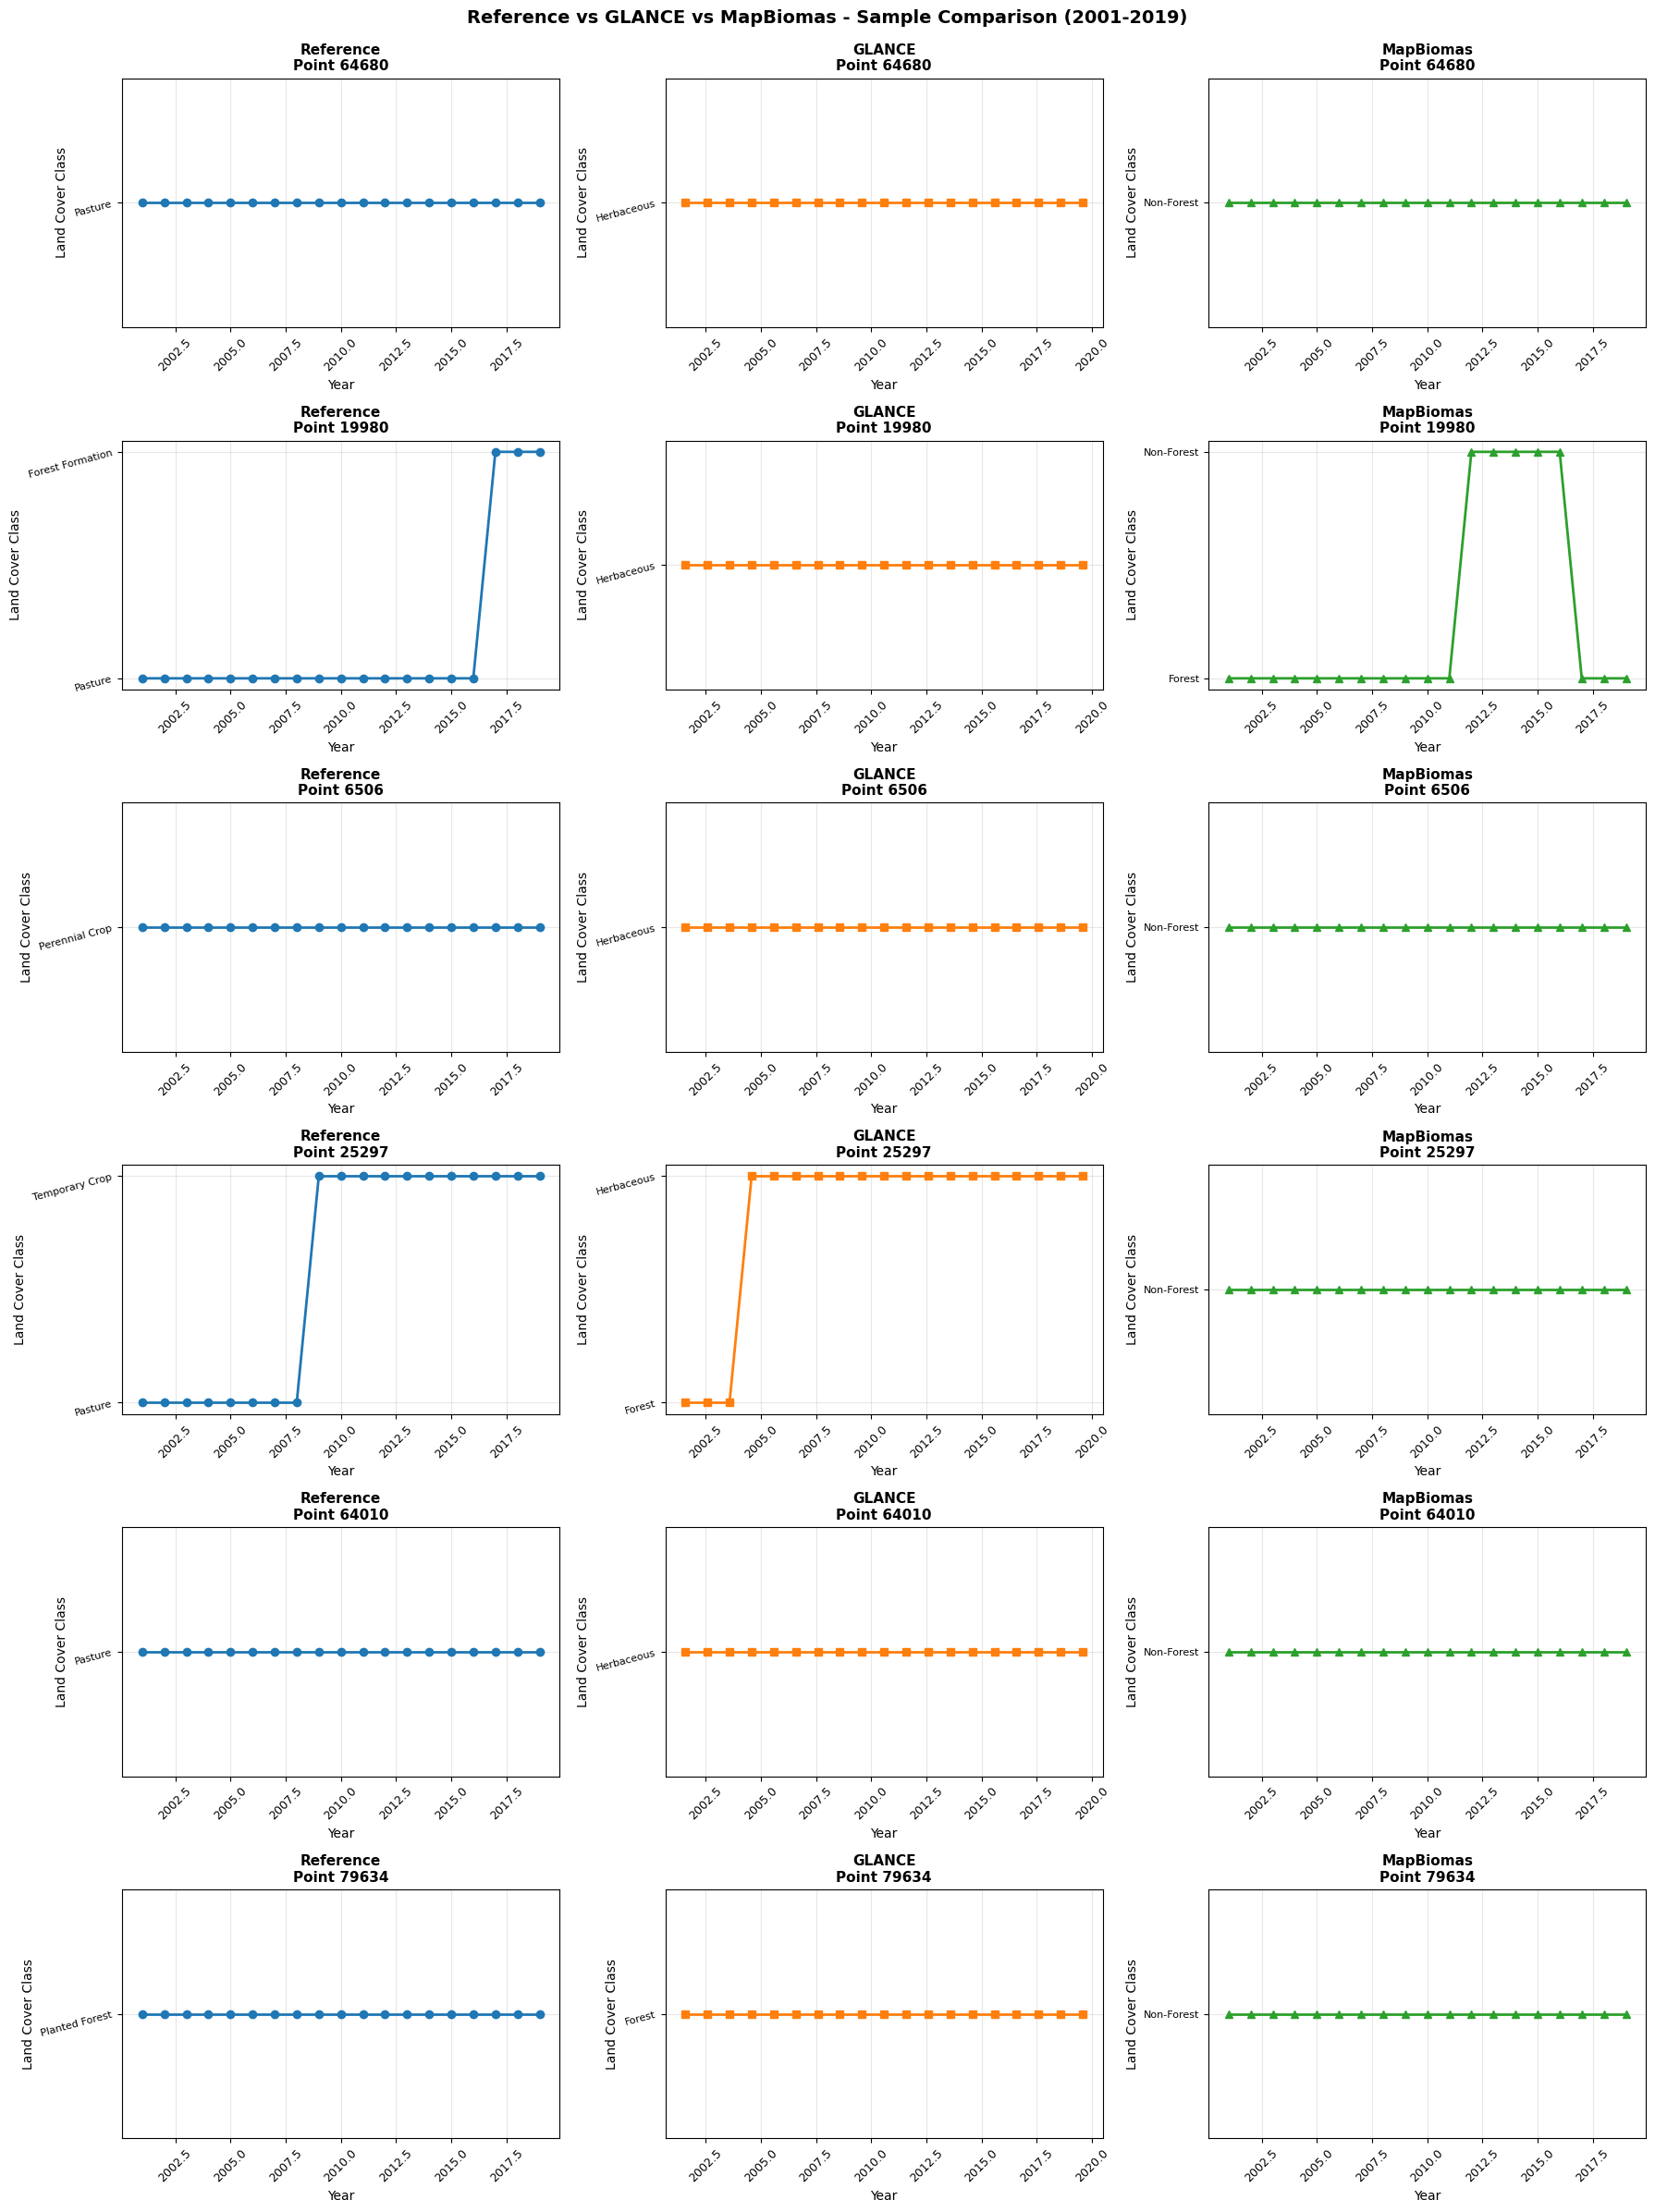


Successfully plotted 6 point(s)


In [ ]:
# Join with reference validation data and plot selected or random samples by target_id
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Merge GLANCE and MapBiomas data on target_id
merged_df = pd.merge(gl_df, mb_df, on=['target_id', 'lon', 'lat'], how='inner')

# Join with reference validation data
# Match on TARGETID (from df_points) with target_id (from exported CSVs)
ref_df = df_points[['TARGETID', 'LAT', 'LON'] + [f'CLASS_{y}' for y in years]].copy()
ref_df = ref_df.rename(columns={'TARGETID': 'target_id'})

# Merge with reference data
full_df = pd.merge(merged_df, ref_df, on='target_id', how='inner')

print(f"Total points after join: {len(full_df)}")
print(f"Columns: {full_df.columns.tolist()}")

# -----------------------------------------------------------------------------
# Choose points to plot
# Option A: specify target IDs explicitly (set selected_ids to a list of IDs)
# Option B: leave selected_ids empty to use random sampling
# -----------------------------------------------------------------------------
selected_ids = []  # e.g., [75755, 12345, 67890]; empty list → random sample
default_n_plot = 6  # number of random points to plot when selected_ids is empty

if len(selected_ids) > 0:
    # Normalize to int for robust matching
    ids = pd.Series(selected_ids).astype(int).tolist()
    tmp = full_df.copy()
    tmp['_tid_int'] = tmp['target_id'].astype(int)
    sample_plot_df = (
        tmp[tmp['_tid_int'].isin(ids)]
        .drop(columns=['_tid_int'])
        .reset_index(drop=True)
    )
    found_ids = sorted(sample_plot_df['target_id'].astype(int).unique().tolist())
    missing_ids = sorted(list(set(ids) - set(found_ids)))
    n_plot = len(sample_plot_df)
    print(f"Plotting by IDs. Requested: {ids}")
    print(f"  Found:    {found_ids}")
    if missing_ids:
        print(f"  Missing:  {missing_ids}")
    if n_plot == 0:
        raise ValueError("No rows matched the provided selected_ids. Please check the IDs or use random sampling.")
else:
    # Randomly sample points to plot
    n_plot = min(default_n_plot, len(full_df))
    if n_plot == 0:
        raise ValueError("No data available to plot after join.")
    rng = np.random.RandomState(seed=123)
    sample_indices = rng.choice(len(full_df), n_plot, replace=False)
    sample_plot_df = full_df.iloc[sample_indices].reset_index(drop=True)
    print(f"Plotting {n_plot} randomly sampled points (seed=123)")

# MapBiomas forest class codes (same as before)
mb_forest_classes = [1, 3, 4, 5, 6, 49]
forest_classes_ref = ['Forest Formation', 'Savanna Formation', 'Flooded Forest', 'Planted Forest']

# GLANCE class names
glance_class_names = {1: 'Water', 2: 'Snow/Ice', 3: 'Developed', 4: 'Barren', 
                     5: 'Forest', 6: 'Shrubland', 7: 'Herbaceous'}

# Create figure with 3 columns and n_plot rows
fig, axes = plt.subplots(n_plot, 3, figsize=(18, 4*n_plot))
if n_plot == 1:
    axes = axes.reshape(1, -1)

for idx in range(n_plot):
    row = sample_plot_df.iloc[idx]
    target_id = int(row['target_id'])
    
    # === Subplot 1: Validation/Reference Data ===
    ax1 = axes[idx, 0]
    ref_classes = [row[f'CLASS_{y}'] for y in years]
    ax1.plot(years, ref_classes, marker='o', linewidth=2, markersize=6, color='#1f77b4')
    ax1.set_title(f'Reference\nPoint {target_id}', fontsize=11, fontweight='bold')
    ax1.set_xlabel('Year', fontsize=10)
    ax1.set_ylabel('Land Cover Class', fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)
    ax1.tick_params(axis='y', labelsize=8)
    for label in ax1.get_yticklabels():
        label.set_rotation(15)
        label.set_ha('right')
    
    # === Subplot 2: GLANCE ===
    ax2 = axes[idx, 1]
    gl_values = [row[f'gl_{y}'] for y in years]
    gl_classes = [glance_class_names.get(int(v), 'Unknown') if pd.notna(v) else 'No Data' for v in gl_values]
    ax2.plot(np.array(years)+7.0/12.0, gl_classes, marker='s', linewidth=2, markersize=6, color='#ff7f0e')
    ax2.set_title(f'GLANCE\nPoint {target_id}', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Year', fontsize=10)
    ax2.set_ylabel('Land Cover Class', fontsize=10)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)
    ax2.tick_params(axis='y', labelsize=8)
    for label in ax2.get_yticklabels():
        label.set_rotation(15)
        label.set_ha('right')
    
    # === Subplot 3: MapBiomas ===
    ax3 = axes[idx, 2]
    mb_values = [row[f'mb_{y}'] for y in years]
    mb_classes = []
    for v in mb_values:
        if pd.notna(v):
            v_int = int(v)
            if v_int in mb_forest_classes:
                mb_classes.append('Forest')
            else:
                mb_classes.append('Non-Forest')
        else:
            mb_classes.append('No Data')
    
    ax3.plot(years, mb_classes, marker='^', linewidth=2, markersize=6, color='#2ca02c')
    ax3.set_title(f'MapBiomas\nPoint {target_id}', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Year', fontsize=10)
    ax3.set_ylabel('Land Cover Class', fontsize=10)
    ax3.grid(True, alpha=0.3)
    ax3.tick_params(axis='x', rotation=45, labelsize=9)
    ax3.tick_params(axis='y', labelsize=8)
    
    print(f"\nPoint {target_id}:")
    print(f"  Reference 2001: {ref_classes[0]} → 2019: {ref_classes[-1]}")
    print(f"  GLANCE 2001: {gl_classes[0]} → 2019: {gl_classes[-1]}")
    print(f"  MapBiomas 2001: {mb_classes[0]} → 2019: {mb_classes[-1]}")

plt.suptitle('Reference vs GLANCE vs MapBiomas - Sample Comparison (2001-2019)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print(f"Successfully plotted {n_plot} point(s)")
print(f"{'='*80}")


In [ ]:
300/0.9


333.3333333333333